# Defining and loading data

### Preprocessing:

##### Loading custiom modules

In [13]:
#!/bin/env python3.7

# load custom modules required for CLR training
from modules.TransformerEncoder import Transformer
from modules.ContrastiveLosses import clr_loss,anomclr_loss,anomclr_plus_loss , anomclr_plus_loss_bonus
from modules.fcn_linear import fully_connected_linear_network
from modules.my_jet_augs import rotate_jets, distort_jets, rescale_pts, crop_jets, translate_jets, collinear_fill_jets, collinear_fill_jets_fast , shift_pT ,pt_reweight_jet, drop_constits_jet



# import args from extargs.py file
import My_Anom_extargs as args



# load standard python modules
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
from torch.utils.data import Dataset , TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

#torch.set_default_dtype(torch.float64)
# initialise logfile
logfile = open("/remote/gpu05/rueschkamp/outputs_from_queue/AnomCLR/Debugging/my_debug_logfile.txt", "a" )
print( "logfile initialised"   )

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )
print( "device: " + str( device )    )

#loading in data ------------------------------------------------------------

sys.path.insert(1, '/remote/gpu05/rueschkamp/projects/torch_datasets/')
from top_dataset import My_Dataset
from semi_dataset import SemiV_Dataset
from torch.utils.data import DataLoader

logfile initialised
device: cuda


##### Setting up Dataloader and Transformer


In [14]:
t0 = time.time()
#starting training loader --------------------------------------
n_jets = 1e5
ratio = 0.2
n_constits = 50
batch_size = 128

training_set = SemiV_Dataset(
                                    data_path =args.data_path,
                                    signal_origin= "qcd",
                                    usage= "training",
                                    number_constit=  n_constits,#args.n_constit,
                                    number_of_jets= n_jets,
                                    ratio = ratio
                                    )

dl_training = DataLoader(training_set,batch_size=batch_size, shuffle=True)

t1 = time.time()
print( "time taken to load and preprocess data: "+str( np.round( t1-t0, 2 ) ) + " seconds"    )


#initializing the network 
input_dim = 3 

net = Transformer( input_dim, args.model_dim, args.output_dim, args.n_heads, args.dim_feedforward, args.n_layers, args.learning_rate, args.n_head_layers, dropout=0.1, opt=args.opt )
# send network to device
net.to( device )

time taken to load and preprocess data: 25.05 seconds


Transformer(
  (embedding): Linear(in_features=3, out_features=1000, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1000, out_features=1000, bias=True)
        )
        (linear1): Linear(in_features=1000, out_features=1000, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1000, out_features=1000, bias=True)
        (norm1): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1000, out_features=1000, bias=True)
        )
        (linear1): Linear(in_f

##### Setting up save directory:

In [ ]:
# set up results directory
base_dir = "/remote/gpu05/rueschkamp/outputs_from_queue/AnomCLR/Debugging/" 
expt_tag = "Speed" #args.expt
expt_dir = base_dir + "experiments/" + expt_tag + "/"
#print(expt_dir)
# check if experiment already exists
if os.path.isdir(expt_dir):
    sys.exit("ERROR: experiment already exists, don't want to overwrite it by mistake")
else:
    os.makedirs(expt_dir)
print("experiment: "+str(expt_tag))

# Training Loop 

## AnomCLR

### Training Model

In [111]:
losses = []
stars = []
dashes = []

breaker = 1
# the loop
for epoch in range( args.n_epochs +1):
    # initialise timing stats
    losses_e = []
    stars_e = [] #anomaly
    dashes_e = [] # physical

    print("epoch: ",epoch )
    for i, (data, labels) in enumerate(dl_training):
        net.optimizer.zero_grad()
        x_i = data
        
        # print(x_i.shape) # checking what Tensor is fed into the augmentations
        x_i = rotate_jets( x_i ) # to undo the previos centring
        x_j = x_i.clone()
        x_k = x_i.clone()


        # POSITIVE AUGMENTATIONS
        x_j = rotate_jets( x_j ) 
        x_j = collinear_fill_jets_fast( x_j )
        x_j = collinear_fill_jets_fast( x_j ) #Why two times?
        x_j = distort_jets( x_j, strength=args.ptst, pT_clip_min=args.ptcm )

        x_i = translate_jets( x_i, width=args.trsw )
        x_j = translate_jets( x_j, width=args.trsw )
        x_k = translate_jets( x_k, width=args.trsw ) # what if we would skip this?

        # NEGATIVE AUGMENTATIONS
        
        x_k = drop_constits_jet(x_k, 0.17)

        # Getting representations
        x_i = rescale_pts( x_i )
        x_j = rescale_pts( x_j )
        x_k = rescale_pts(x_k)


        x_i = x_i.transpose(1,2)
        x_j = x_j.transpose(1,2)
        x_k = x_k.transpose(1,2)
        
        #filename = expt_dir+ f"brokeModel.pt"
        #torch.save(net.state_dict(), filename)

        z_i  = net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask) #dim: x_i = torch.Size([104, 50, 3]) and z_i = torch.Size([104, 1000])
        z_j = net(x_j, use_mask=args.mask, use_continuous_mask=args.cmask)
        z_k = net(x_k,use_mask = args.mask, use_continuous_mask = args.cmask)

        if torch.isnan(z_k).any():
            
            print("Representation, Size:",z_k.size(),'Full Tensor:',z_k  )
            print("x_i, Size:",x_k.size(),'Full Tensor:',x_k   )
            if torch.isnan(x_k).any():
                print("the reason must be the dropping function")
            else:
                print("the x batch is free of Nans!")

            torch.save(x_k, expt_dir + f"problematic_Tensor.pt")
            torch.save(x_j, expt_dir + f"physical_Tensor.pt")
            torch.save(x_i, expt_dir + f"origin_Tensor.pt")
        
            breaker = 0
        # compute the loss, back-propagate, and update scheduler if required
        loss , star , dash = anomclr_plus_loss_bonus( z_i, z_j, z_k,args.temperature )
        loss = loss.to( device )
        #print(loss)
        loss.backward()
        net.optimizer.step()
        losses_e.append( loss.detach().cpu().numpy() )
        stars_e.append(np.mean(star.detach().cpu().numpy()))
        dashes_e.append(np.mean(dash.detach().cpu().numpy()))


        
        if breaker==0:
            break
        #print(loss)
    if breaker==0:
            break    
        

epoch:  0
tensor([1.3338, 1.0333, 1.1813, 1.0114, 1.2388, 1.1414, 1.5331, 1.6023, 1.2141,
        1.4402, 1.1864, 1.0817, 1.2313, 1.0552, 1.2701, 1.1629, 1.0883, 1.1139,
        1.1453, 1.3876, 1.1280, 1.0039, 1.6039, 1.1184, 1.2517, 1.1515, 1.1587,
        1.2161, 1.1258, 1.4095, 1.8815, 1.3262, 1.3241, 1.2403, 1.0068, 1.6097,
        1.2045, 1.3817, 1.2675, 1.2816, 1.1341, 1.3315, 1.0306, 1.0755, 1.1867,
        1.0414, 1.3514, 1.1579, 1.4692, 1.3201, 1.0456, 1.1353, 1.0380, 1.1941,
        1.3756, 1.1472, 1.2810, 1.0096, 1.0351, 1.0241, 1.0119, 1.1912, 1.1661,
        1.1609, 1.2776, 1.2089, 1.6672, 1.1590, 1.1805, 1.1396, 1.4096, 1.5741,
        1.2540, 1.2206, 1.1808, 1.3976, 1.0746, 1.2392, 1.2814, 1.2018, 1.1277,
        1.3609, 1.1472, 1.0578, 1.0563, 1.0147, 1.1257, 1.0180, 1.4079, 1.1619,
        1.1681, 1.1758, 1.1300, 1.0482, 1.0584, 1.1652, 1.2505, 1.2250, 1.1837,
        1.1587, 1.3157, 1.0644, 1.1869, 1.0507, 1.1059, 1.2026, 1.3904, 1.1592,
        1.1865, 1.3787, 1.0435

KeyboardInterrupt: 

### Training Model with hooks


In [ ]:
# Plot the training loss
def plotingstuff(epoch,stars,dashes):
    x = np.linspace(0, epoch - 1, epoch)

    fig, ax1 = plt.subplots()
    ax1.plot(x, losses, label="loss")
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f"AnomCLR Loss with {args.n_jets:.0e} jets")
    ax1.legend()
    
    plt.savefig((expt_dir+f"CLR-Loss_{epoch}epochs_{n_jets:.0e}Jets.pdf"), format="pdf")

    # Create a new figure and axes for the second plot
    fig, ax2 = plt.subplots()
    ax2.plot(x, stars, label="Anomaly Similarity")
    ax2.plot(x, dashes, label="Physical Similarity")
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Similarity')
    ax2.set_title('Similarity of the Transformer Network')
    ax2.legend()
    plt.savefig((expt_dir+f"Similarities_{epoch}epochs_{n_jets:.0e}Jets.pdf"), format="pdf")

In [ ]:
print(net.named_parameters)

In [ ]:
net = Transformer( input_dim, args.model_dim, args.output_dim, args.n_heads, args.dim_feedforward, args.n_layers, args.learning_rate, args.n_head_layers, dropout=0.1, opt=args.opt )
# send network to device
net.to( device )

norm2 = 1

# Define the forward hook function
# Define the forward hook function
def print_layer_output(module, input, output):
    if isinstance(output, tuple):
        for i, out in enumerate(output):
            if out is not None:
                print(f"Output shape {i+1} of {module.__class__.__name__}: {out.shape}")
    else:
        print(f"Output shape of {module.__class__.__name__}: {output.shape}")


# Define the forward hook function
def print_layer_output(module, input, output):
    if isinstance(output, tuple):
        for i, out in enumerate(output):
            if out is not None:
                print(f"Output shape {i+1} of {module.__class__.__name__}: {out.shape}")
                if module.__class__.__name__ == 'norm2':
                    norm2 = out
                    # torch.save(out, 'norm2_output.pth')
    else:
        print(f"Output shape of {module.__class__.__name__}: {output.shape}")
        if module.__class__.__name__ == 'norm2':
            norm2 = out
            # torch.save(output, 'norm2_output.pth')



# Register the forward hook for each layer
for name, module in net.named_modules():
    if isinstance(module, nn.Module):
        module.register_forward_hook(print_layer_output)

# Test your network
#input_tensor = torch.randn(128, 50,3)
#output = net(input_tensor)

In [7]:
print( "starting training loop, running for " + str( args.n_epochs ) + " epochs"    )
print( "---"    )


net = Transformer( input_dim, args.model_dim, args.output_dim, args.n_heads, args.dim_feedforward, args.n_layers, args.learning_rate, args.n_head_layers, dropout=0.1, opt=args.opt )
# send network to device
net.to( device )

norm2 =[]

def print_layer_output(module, input, output):
    if isinstance(output, tuple):
        for i, out in enumerate(output):
            if out is not None:
                print(f"Output shape {i+1} of {module.__class__.__name__}: {out.max()}", file=logfile, flush=True )
                if module.__class__.__name__ == 'norm2':
                    norm2.append( out)
                    # torch.save(out, 'norm2_output.pth')
    else:
        print(f"Output shape of {module.__class__.__name__}: {output.max()}", file=logfile, flush=True )
        if module.__class__.__name__ == 'norm2':
            norm2 = norm2.append( output)
            # torch.save(output, 'norm2_output.pth')



# Register the forward hook for each layer
for name, module in net.named_modules():
    if isinstance(module, nn.Module):
        module.register_forward_hook(print_layer_output)

losses = []
stars = []
dashes = []

epochs = 100
breaker = 1
# the loop
#for epoch in range( args.n_epochs ):
for epoch in range( epochs):
    # initialise timing stats
    losses_e = []
    stars_e = []
    dashes_e = []

    #if epoch%10 ==0 and epoch> 0:
    #    plotingstuff(epoch,stars,dashes)


    print("epoch: ",epoch)
    for i, (data, labels) in enumerate(dl_training):
        net.optimizer.zero_grad()
        x_i = data
        
        # print(x_i.shape) # checking what Tensor is fed into the augmentations
        x_i = rotate_jets( x_i ) # to undo the previos centring
        x_j = x_i.clone()
        x_k = x_i.clone()


        # POSITIVE AUGMENTATIONS
        x_j = rotate_jets( x_j ) 
        x_j = collinear_fill_jets_fast( x_j )
        x_j = collinear_fill_jets_fast( x_j ) #Why two times?
        x_j = distort_jets( x_j, strength=args.ptst, pT_clip_min=args.ptcm )

        x_i = translate_jets( x_i, width=args.trsw )
        x_j = translate_jets( x_j, width=args.trsw )
        x_k = translate_jets( x_k, width=args.trsw ) # what if we would skip this?

        x_i = rescale_pts( x_i )
        x_j = rescale_pts( x_j )
        # NEGATIVE AUGMENTATIONS
        

        x_k = drop_constits_jet(x_k, 0.6)
        
        # Getting representations

        pTs= x_k[:,0,:]
        non_zero_count = torch.sum(pTs != 0, dim=-1, keepdim=True)
        if torch.min(non_zero_count) == 0:
            print("Its all Zeroooo")


        x_i = x_i.transpose(1,2)
        x_j = x_j.transpose(1,2)
        x_k = x_k.transpose(1,2)





        z_i  = net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask) #dim: x_i = torch.Size([104, 50, 3]) and z_i = torch.Size([104, 1000])
        z_j = net(x_j, use_mask=args.mask, use_continuous_mask=args.cmask)
        z_k = net(x_k,use_mask = args.mask, use_continuous_mask = args.cmask)

        if torch.isnan(z_k).any():
            
            print("Representation, Size:",z_k.size(),'Full Tensor:',z_k )
            print("x_i, Size:",x_k.size(),'Full Tensor:',x_k )
            breaker = 0
        # compute the loss, back-propagate, and update scheduler if required
        loss , star , dash = anomclr_plus_loss_bonus( z_i, z_j, z_k,args.temperature )
        loss = loss.to( device )
        loss.backward()
        net.optimizer.step()
        losses_e.append( loss.detach().cpu().numpy() )
        stars_e.append(np.mean(star.detach().cpu().numpy()))
        dashes_e.append(np.mean(dash.detach().cpu().numpy()))

        print("##################NEW ITERATION ##########################", file=logfile, flush=True)
        print("##################NEW ITERATION ############################################NEW ITERATION ############################################NEW ITERATION ############################################NEW ITERATION ############################################NEW ITERATION ############################################NEW ITERATION ############################################NEW ITERATION ############################################NEW ITERATION ##########################", file=logfile, flush=True)
                
        # Print the gradients of the optimizer
        #for name, param in net.named_parameters():
        #    if param.grad is not None:
        #        print(f"Parameter: {name}, Gradient: {param.grad}")
        
        if breaker==0:
            break
        
    if breaker==0:
            break    
        
                
    loss_e = np.mean( np.array( losses_e ) )
    print(loss_e)
    losses.append( loss_e )

    star_e = np.mean(np.array(stars_e))
    print(star_e)
    stars.append(star_e)

    dash_e = np.mean(np.array(dashes_e))
    print(dash_e)
    dashes.append(dash_e)


starting training loop, running for 300 epochs
---
epoch:  0
Its all Zeroooo
Representation, Size: torch.Size([128, 1000]) Full Tensor: tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
x_i, Size: torch.Size([128, 50, 3]) Full Tensor: tensor([[[ 5.5245e+01, -3.6175e-01,  6.2038e-01],
         [ 1.8177e+01, -4.2003e-01,  6.9178e-01],
         [ 1.6978e+01, -3.1191e-01,  6.1474e-01],
         ...,
         [ 0.0000e+00,  9.3102e-02, -2.0548e-01],
         [ 0.0000e+00, -6.2591e-01, -7.8230e-01],
         [ 0.0000e+00,  9.3102e-02, -2.0548e-01]],

        [[ 3.6371e+01, -2.2802e+00, -4.4474e-01],
         [ 1.8873e+01, -2.3308e+00, -5.6912e-01],
         [ 1.7837e+01, -2.2067e+00, -5.4335e-01],
         

In [6]:
non_zero_count.size()

torch.Size([128, 1])

In [ ]:
# Plot the training loss
x = np.linspace(0,epochs-1,epochs)
#print(z_k)
plt.plot(x, losses, label = "loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Contrastive Learning Network Loss')
plt.legend()
plt.show()


In [ ]:
x = np.linspace(0,epochs-1,epochs)
plt.plot(x, stars, label = "Anomaly Similarity")
plt.plot(x, dashes, label = "Physical Similarity")
plt.xlabel('Epoch')
plt.ylabel('Similarity')
plt.title('Similarity of the Transformer Network')
plt.legend()
plt.show()

### Saving the Model

In [ ]:
tms0 = time.time()

filename = f"/remote/gpu05/rueschkamp/outputs_from_queue/AnomCLR/Debugging/Model_{epochs}epochs_{n_jets:.0e}Jets.pt"
torch.save(net.state_dict(), filename)
tms1 = time.time()
print( f"time taken to save model: {round( tms1-tms0, 1 )}s" )

### Loading Model

In [15]:
loading_model = True
if loading_model :
    # Create an instance of your model
    net = Transformer( input_dim, args.model_dim, args.output_dim, args.n_heads, args.dim_feedforward, args.n_layers, args.learning_rate, args.n_head_layers, dropout=0.1, opt=args.opt )

    # Load the saved state dictionary
    #state_dict = torch.load("/remote/gpu05/rueschkamp/outputs_from_queue/AnomCLR/Model_21epochs_1e+04Jets.pt")
    epochs = 300
    n_jets =1e5
    Transformer_filename = f"/remote/gpu05/rueschkamp/outputs_from_queue/AnomCLR/plus/experiments/RunDrop0.3allpos_checkrescaling/Model_{epochs}epochs_{n_jets:.0e}Jets.pt"
    #Transformer_filename = f"/remote/gpu05/rueschkamp/outputs_from_queue/AnomCLR/plus/Longrun/Model_{epochs}epochs_{n_jets:.0e}Jets.pt"
    state_dict = torch.load(Transformer_filename)
    # Load the state dictionary into the model
    net.load_state_dict(state_dict)
    net.to(device)
    net.eval()

# AE


## Loading Data and Creating AE

In [ ]:
if loading_model:
    training_set = SemiV_Dataset(
                                        data_path =args.data_path,
                                        signal_origin= "qcd",
                                        usage= "training",
                                        number_constit=  args.n_constit,#args.n_constit,
                                        number_of_jets= args.n_jets,
                                        ratio = ratio
                                        )

    dl_training = DataLoader(training_set,batch_size=args.batch_size, shuffle=True)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder network
        self.encoder = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),
            nn.Linear(16, 8)
        )
        
        # Decoder network
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(True),
            nn.Linear(16, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1000),
            #nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
model=Autoencoder()
model.to(device);

In [ ]:
if loading_model:
    model = Autoencoder()
    AE_filename = "/remote/gpu05/rueschkamp/outputs_from_queue/AnomCLR/AE/experiments/TryAESpiking/Model_100epochs_1e+05Jets.pt"
    state_dict = torch.load(AE_filename)
    # Load the state dictionary into the model
    model.load_state_dict(state_dict)
    model.to(device)

## Training

In [ ]:
import collections
from tqdm import tqdm, tqdm_notebook # for the progress bar


net.eval()


criterion=nn.MSELoss()
learning_rate = 1e-3
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

# Utilize a named tuple to keep track of scores at each epoch
model_hist = collections.namedtuple('Model','epoch loss val_loss')
model_loss = model_hist(epoch = [], loss = [], val_loss = [])

def train(epochs, model, model_loss,train_dataloader):
    try: c = model_loss.epoch[-1]
    except: c = 0
    for epoch in tqdm_notebook(range(epochs),position=0, total = epochs):
        epoch_loss = 0.0
        num_batches = 0

        for i, (inputs, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            #preprocess
            x_i = inputs
            time1 = time.time()
            x_i = x_i.transpose(1,2) 
            point_on_sphere = net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask )



            outputs = model(point_on_sphere)
            loss = criterion(outputs, point_on_sphere)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        model_loss.epoch.append(c+epoch)
        model_loss.loss.append(loss.item())
        t = time.time()
        print(f"Epoch {epoch}: loss={epoch_loss:.4f} time taken{round(t1-t,2)}")

epochs = 10

train(model =model , epochs = epochs, model_loss =model_loss,train_dataloader=dl_training) #AE

In [ ]:
x = np.linspace(0, epochs-1 , epochs)
plt.plot(x, model_loss.loss, label="loss")
#plt.yscale("log")
plt.legend()

In [ ]:
print(model)

## Verification for AE

In [ ]:
n_jets = 10000
testing_set_aachen = SemiV_Dataset(
                                    data_path =args.data_path,
                                    signal_origin= "aachen",
                                    usage= "testing",
                                    number_constit= args.n_constit,
                                    number_of_jets= n_jets,
                                    ratio = ratio
                                    )

dl_AE_testing_aachen = DataLoader(testing_set_aachen,batch_size=args.batch_size, shuffle=False)

testing_set_heidelberg = SemiV_Dataset(
                                    data_path =args.data_path,
                                    signal_origin= "heidelberg",
                                    usage= "testing",
                                    number_constit= args.n_constit,
                                    number_of_jets= n_jets,
                                    ratio = ratio
                                    )

dl_AE_testing_heidelberg = DataLoader(testing_set_heidelberg,batch_size=args.batch_size, shuffle=False)

testing_set_top = My_Dataset("/remote/gpu05/rueschkamp/data/Jandata/Zendoo/train.h5",
                                  "/remote/gpu05/rueschkamp/data/Jandata/Zendoo/val.h5",
                                  "/remote/gpu05/rueschkamp/data/Jandata/Zendoo/test.h5",
                                  "testing",
                                  50,
                                  number_of_jets= n_jets)

dl_AE_testing_top = DataLoader(testing_set_top,batch_size=args.batch_size, shuffle=False)

print(len(dl_AE_testing_heidelberg))

#### Aachen

In [ ]:
criterion =nn.MSELoss()

def calculate_errors(model, criterion, dataloader):
    errors = []
    model.eval() # set model to evaluation mode

    with torch.no_grad(): # turn off gradients since we're only evaluating
        for inputs, label in dataloader:
            x_i = inputs

            x_i =  x_i.transpose(1,2)

            point_on_sphere = net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask )
            outputs = model(point_on_sphere)
            #print(point_on_sphere.shape)
            #outputs = sigmoid(model(point_on_sphere))
            for i in range(len(point_on_sphere)):
                
                loss = criterion(outputs[i], point_on_sphere[i]) 
                errors.extend([loss.to(torch.device("cpu")).numpy()])

    return np.array(errors)

def get_true_labels(data_loader):
    labels = []
    for batch in data_loader:
        _, batch_labels = batch
        labels.extend(batch_labels.to(torch.device("cpu")).numpy().tolist())
    return np.array(labels)

output_net_aachen = calculate_errors(model ,criterion, dl_AE_testing_aachen)
labels_net_aachen = get_true_labels(dl_AE_testing_aachen)

print(output_net_aachen)
print(labels_net_aachen)

In [ ]:
fpr, tpr, thresholds = roc_curve(labels_net_aachen, output_net_aachen) #getting the data needed to plot the ROC curve
roc_auc = auc(fpr, tpr) #getting the AUC
# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([1e-4, 1.0])  # set the lower limit to 0.0001 for logarithmic y-axis
plt.xscale('linear')     # set x-axis to linear scale
#plt.yscale('log')        # set y-axis to logarithmic scale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve Aachen')
plt.legend(loc="lower right")
plt.show()

#### Heidelberg

In [ ]:
output_net_heidelberg = calculate_errors(model ,criterion, dl_AE_testing_heidelberg)
labels_net_heidelberg = get_true_labels(dl_AE_testing_heidelberg)

fpr, tpr, thresholds = roc_curve(labels_net_heidelberg, output_net_heidelberg) #getting the data needed to plot the ROC curve
roc_auc = auc(fpr, tpr) #getting the AUC
# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([1e-4, 1.0])  # set the lower limit to 0.0001 for logarithmic y-axis
plt.xscale('linear')     # set x-axis to linear scale
#plt.yscale('log')        # set y-axis to logarithmic scale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve Heidelberg')
plt.legend(loc="lower right")
plt.show()

#### Top


In [ ]:
output_net_top = calculate_errors(model ,criterion, dl_AE_testing_top)
labels_net_top = get_true_labels(dl_AE_testing_top)

fpr, tpr, thresholds = roc_curve(labels_net_top, output_net_top) #getting the data needed to plot the ROC curve
roc_auc = auc(fpr, tpr) #getting the AUC
# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([1e-4, 1.0])  # set the lower limit to 0.0001 for logarithmic y-axis
plt.xscale('linear')     # set x-axis to linear scale
#plt.yscale('log')        # set y-axis to logarithmic scale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve Top')
plt.legend(loc="lower right")
plt.show()

## Verification in many steps

In [ ]:
def plottingROC(model,criterion,dataloader,Dataorigin,epoch):    

    output_net_top = calculate_errors(model ,criterion, dataloader)
    labels_net_top = get_true_labels(dataloader)

    fpr, tpr, thresholds = roc_curve(labels_net_top, output_net_top) #getting the data needed to plot the ROC curve
    roc_auc = auc(fpr, tpr) #getting the AUC
    # Plot the ROC curve
    fig, ax = plt.subplots(figsize=(8, 6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([1e-4, 1.0])  # set the lower limit to 0.0001 for logarithmic y-axis
    plt.xscale('linear')     # set x-axis to linear scale
    #plt.yscale('log')        # set y-axis to logarithmic scale
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve '+ Dataorigin)
    plt.legend(loc="lower right")

    if Dataorigin== "aachen":
        AUC_aachen.append(roc_auc)
        plt.savefig(expt_dir+ f"/AUC_Aachen_epoch:{epoch}.pdf",format="pdf")

    if Dataorigin== "heidelberg":
        AUC_heidelberg.append(roc_auc)
        plt.savefig(expt_dir+ f"/AUC_heidelberg_epoch:{epoch}.pdf",format="pdf")

    if Dataorigin== "top":
        AUC_top.append(roc_auc)
        plt.savefig(expt_dir+ f"/AUC_top_epoch:{epoch}.pdf",format="pdf")

In [ ]:
import collections
from tqdm import tqdm, tqdm_notebook # for the progress bar

net.eval()
model=Autoencoder()
model.to(device)

criterion=nn.MSELoss()
learning_rate = 1e-3
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

# Utilize a named tuple to keep track of scores at each epoch
model_hist = collections.namedtuple('Model','epoch loss val_loss')
model_loss = model_hist(epoch = [], loss = [], val_loss = [])

AUC_aachen = []
AUC_heidelberg =[]
AUC_top =[]

checking_iteration = 5

def train(epochs, model, model_loss,train_dataloader):
    try: c = model_loss.epoch[-1]
    except: c = 0
    for epoch in tqdm_notebook(range(epochs +1),position=0, total = epochs+1):
        epoch_loss = 0.0
        num_batches = 0

        

        if epoch%checking_iteration == 0 and epoch > 0:
            model.eval
            plottingROC(model,criterion,dl_AE_testing_aachen,"aachen",epoch)
            plottingROC(model,criterion,dl_AE_testing_heidelberg,"heidelberg",epoch)
            plottingROC(model,criterion,dl_AE_testing_top,"top",epoch)
            model.train
            



        for i, (inputs, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            #preprocess
            x_i = inputs
            time1 = time.time()
            x_i = x_i.transpose(1,2) 
            point_on_sphere = net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask )



            outputs = model(point_on_sphere)
            loss = criterion(outputs, point_on_sphere)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        model_loss.epoch.append(c+epoch)
        model_loss.loss.append(loss.item())
        t = time.time()
        print(f"Epoch {epoch}: loss={epoch_loss:.4f} time taken{round(t1-t,2)}")

epochs = 100

train(model =model , epochs = epochs, model_loss =model_loss,train_dataloader=dl_training) #AE

In [ ]:
checking_iteration = 5

def plottingAUCdevelopment(AUC,checking_iteration,Dataorigin):    

    x = np.linspace(1,len(AUC),len(AUC)) * checking_iteration
    if Dataorigin== "aachen":
        plt.plot(x, AUC, label="loss aachen")
        plt.legend()
        plt.show()
        plt.savefig(expt_dir+ f"/AUC_Aachen_development.pdf",format="pdf")
    elif Dataorigin== "heidelberg":
        plt.plot(x, AUC, label="loss heidelberg")
        plt.legend()
        plt.show()
        plt.savefig(expt_dir+ f"/AUC_Heidelberg_development.pdf",format="pdf")
    elif Dataorigin== "top":
        plt.plot(x, AUC, label="loss top")
        plt.legend()
        plt.show()
        plt.savefig(expt_dir+ f"/AUC_Top_development.pdf",format="pdf")

In [ ]:
plottingAUCdevelopment(AUC_aachen,checking_iteration,"aachen")

In [ ]:
AUC_aachen = [0.3,0.4,0.43,0.5,0.6]

x = np.linspace(1,len(AUC_aachen),len(AUC_aachen)) * epochs/checking_iteration
plt.plot(x, AUC_aachen, label="loss aachen")
plt.legend()
plt.show()

# NAE

## Loading Transformer

# Linear Classifier Test


## Standard

### Loading Data

In [28]:
#####################################Training###########################
n_jets = 50000
LCT_training_set_aachen = SemiV_Dataset(
                                    data_path =args.data_path,
                                    signal_origin= "aachen",
                                    usage= "training",
                                    number_constit= args.n_constit,
                                    number_of_jets= n_jets,
                                    ratio = ratio
                                    )

dl_LCT_training_aachen = DataLoader(LCT_training_set_aachen,batch_size=args.batch_size, shuffle=True)

LCT_training_set_heidelberg = SemiV_Dataset(
                                    data_path =args.data_path,
                                    signal_origin= "heidelberg",
                                    usage= "training",
                                    number_constit= args.n_constit,
                                    number_of_jets= n_jets,
                                    ratio = ratio
                                    )

dl_LCT_training_heidelberg = DataLoader(LCT_training_set_heidelberg,batch_size=args.batch_size, shuffle=True)

LCT_training_top = My_Dataset("/remote/gpu05/rueschkamp/data/Jandata/Zendoo/train.h5",
                                  "/remote/gpu05/rueschkamp/data/Jandata/Zendoo/val.h5",
                                  "/remote/gpu05/rueschkamp/data/Jandata/Zendoo/test.h5",
                                  "training",
                                  50,
                                  number_of_jets= n_jets)

dl_LCT_training_top = DataLoader(LCT_training_top,batch_size=args.batch_size, shuffle=True)

#####################################Testing###################################

LCT_testing_set_aachen = SemiV_Dataset(
                                    data_path =args.data_path,
                                    signal_origin= "aachen",
                                    usage= "testing",
                                    number_constit= args.n_constit,
                                    number_of_jets= n_jets,
                                    ratio = ratio
                                    )

dl_LCT_testing_aachen = DataLoader(LCT_testing_set_aachen,batch_size=args.batch_size, shuffle=False)

LCT_testing_set_heidelberg = SemiV_Dataset(
                                    data_path =args.data_path,
                                    signal_origin= "heidelberg",
                                    usage= "testing",
                                    number_constit= args.n_constit,
                                    number_of_jets= n_jets,
                                    ratio = ratio
                                    )

dl_LCT_testing_heidelberg = DataLoader(LCT_testing_set_heidelberg,batch_size=args.batch_size, shuffle=False)

LCT_testing_top = My_Dataset("/remote/gpu05/rueschkamp/data/Jandata/Zendoo/train.h5",
                                  "/remote/gpu05/rueschkamp/data/Jandata/Zendoo/val.h5",
                                  "/remote/gpu05/rueschkamp/data/Jandata/Zendoo/test.h5",
                                  "testing",
                                  50,
                                  number_of_jets= n_jets)

dl_LCT_testing_top = DataLoader(LCT_testing_top,batch_size=args.batch_size, shuffle=False)

print(len(dl_LCT_training_heidelberg))

391


In [23]:

LCT_training_set_aachen = SemiV_Dataset(
                                    data_path =args.data_path,
                                    signal_origin= "aachen",
                                    usage= "training",
                                    number_constit= args.n_constit,
                                    number_of_jets= 1000,
                                    ratio = ratio
                                    )

dl_LCT_training_aachen = DataLoader(LCT_training_set_aachen,batch_size=args.batch_size, shuffle=True)


### Training 

In [29]:
linear_input_size = args.output_dim
linear_n_epochs = 750
linear_learning_rate = 0.001
linear_batch_size = 128
linear_opt = "adam"
net.eval();

In [30]:
linear_model = fully_connected_linear_network( linear_input_size, 1, linear_opt, linear_learning_rate )
linear_model = linear_model.to(device)

criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
#sigmoid = nn.Sigmoid()
linear_learning_rate = 0.0001

# Utilize a named tuple to keep track of scores at each epoch
import collections # whats this???
model_hist = collections.namedtuple('Model','epoch loss')
model_loss = model_hist(epoch = [], loss = [])


def train(epochs, model, criterion, train_dataloader):
    try:
        c = model_loss.epoch[-1]
    except:
        c = 0

    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0

        for i, (inputs, labels) in enumerate(train_dataloader):
            # Zero the parameter gradients
            model.optimizer.zero_grad()

            # Forward pass, backward pass, and optimize
            # inputs = inputs.to(device)
            labels = labels.to(device)

            #     Stuff from earlier loop
            x_i = inputs
            time1 = time.time()

            x_i = x_i.transpose(1,2) #this should not be a thing lol WTF ______-----____
            
            #print(x_i.shape)
            point_on_sphere = net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask )


            outputs =model(point_on_sphere)
            #outputs = sigmoid(model(point_on_sphere))

            loss = criterion(outputs, labels.unsqueeze(-1).float())
            loss.backward()
            model.optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        model_loss.epoch.append(c+epoch)
        model_loss.loss.append(loss.item())
        print(f"Epoch {epoch}: loss={epoch_loss:.4f}")

In [31]:
train(100,linear_model,criterion,dl_LCT_training_aachen) 

Epoch 0: loss=0.2992
Epoch 1: loss=0.2292
Epoch 2: loss=0.1780
Epoch 3: loss=0.1386
Epoch 4: loss=0.1088
Epoch 5: loss=0.0861
Epoch 6: loss=0.0689
Epoch 7: loss=0.0555
Epoch 8: loss=0.0451
Epoch 9: loss=0.0369
Epoch 10: loss=0.0303
Epoch 11: loss=0.0251
Epoch 12: loss=0.0208
Epoch 13: loss=0.0174
Epoch 14: loss=0.0145
Epoch 15: loss=0.0122
Epoch 16: loss=0.0102
Epoch 17: loss=0.0086
Epoch 18: loss=0.0072
Epoch 19: loss=0.0061
Epoch 20: loss=0.0051
Epoch 21: loss=0.0043
Epoch 22: loss=0.0037
Epoch 23: loss=0.0031
Epoch 24: loss=0.0026
Epoch 25: loss=0.0022
Epoch 26: loss=0.0019
Epoch 27: loss=0.0016
Epoch 28: loss=0.0014
Epoch 29: loss=0.0012
Epoch 30: loss=0.0010
Epoch 31: loss=0.0008
Epoch 32: loss=0.0007
Epoch 33: loss=0.0006
Epoch 34: loss=0.0005
Epoch 35: loss=0.0004
Epoch 36: loss=0.0004
Epoch 37: loss=0.0003
Epoch 38: loss=0.0003
Epoch 39: loss=0.0002
Epoch 40: loss=0.0002
Epoch 41: loss=0.0002
Epoch 42: loss=0.0001
Epoch 43: loss=0.0001
Epoch 44: loss=0.0001
Epoch 45: loss=0.000

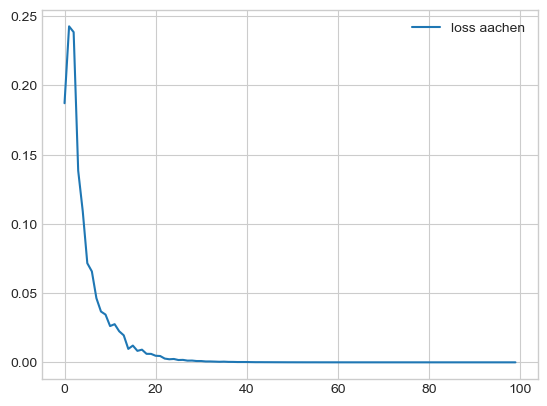

In [33]:
x = np.linspace(0,100-1 , 100)
plt.plot(x, model_loss.loss, label="loss aachen")
plt.legend()
plt.show()

In [34]:
def calculate_errors(CLR_model,LCT_model, dataloader):
    errors = []
    output =[]
    #print(CLR_model)
    #print(LCT_model)
    CLR_model.eval() # set model to evaluation mode
    LCT_model.eval()
    with torch.no_grad(): # turn off gradients since we're only evaluating
        for inputs, labels in dataloader:
            
            x_i = inputs

            x_i =  x_i.transpose(1,2)
            
            point_on_sphere = CLR_model(x_i, use_mask=args.mask, use_continuous_mask=args.cmask)
            outputs = LCT_model(point_on_sphere).to(torch.device("cpu"))
            
            output.extend(outputs)

    return np.array(output)

def calculate_errors_old(model, criterion, dataloader):
    errors = []
    model.eval() # set model to evaluation mode
    with torch.no_grad(): # turn off gradients since we're only evaluating
        for inputs, labels in dataloader:
            
            x_i = inputs

            x_i =  x_i.transpose(1,2)

            point_on_sphere = net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask )

            #point_on_sphere = F.normalize(point_on_sphere, dim=-1)

            #outputs = sigmoid(model(point_on_sphere))
            outputs = model(point_on_sphere)

            criterion = nn.BCEWithLogitsLoss(reduction = 'none')
            loss = criterion(outputs.to(torch.device("cpu")),labels.unsqueeze(-1).to(torch.device("cpu")).float()) 
            errors.extend(loss.to(torch.device("cpu")))

    return np.array(errors)

def get_true_labels(data_loader):
    labels = []
    for batch in data_loader:
        _, batch_labels = batch
        labels.extend(batch_labels.to(torch.device("cpu")).numpy().tolist())
    return np.array(labels)

errors_net = calculate_errors_old(linear_model, criterion , dl_LCT_testing_aachen)
output_net = calculate_errors(net,linear_model, dl_LCT_testing_aachen)
labels_net = get_true_labels(dl_LCT_testing_aachen)
#print(labels_net)
print(errors_net.shape)
print(output_net.shape)

/tmp/ipykernel_2048093/3814961175.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(errors)
/tmp/ipykernel_2048093/3814961175.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(errors)
/tmp/ipykernel_2048093/3814961175.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding p

(20000,)
(20000,)


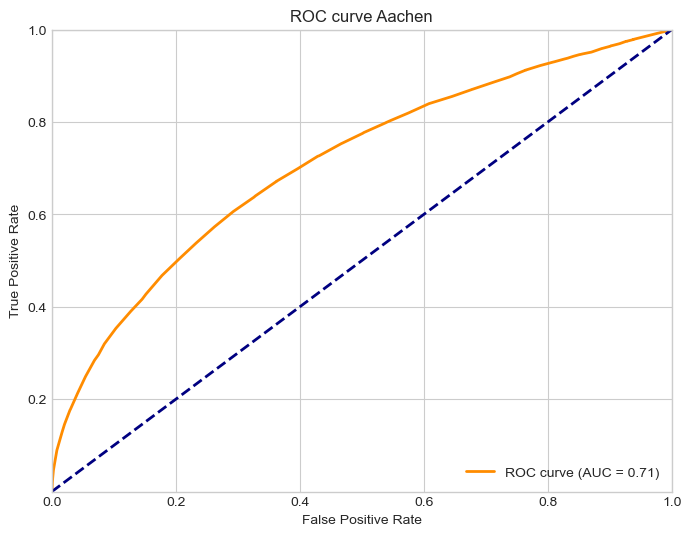

In [35]:
fpr, tpr, thresholds = roc_curve(labels_net, output_net) #getting the data needed to plot the ROC curve
roc_auc = auc(fpr, tpr) #getting the AUC

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([1e-4, 1.0])  # set the lower limit to 0.0001 for logarithmic y-axis
plt.xscale('linear')     # set x-axis to linear scale
#plt.yscale('log')        # set y-axis to logarithmic scale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Aachen')
plt.legend(loc="lower right")
plt.show()

## Pre-Normed

### Loading Data

In [9]:
# Load representations_qcd_normalized_tensor

batch_size =128
representations_qcd_normalized_tensor = torch.load("/remote/gpu05/rueschkamp/data/Jandata/Representations/representations_qcd_normalized_tensor.pt").to(device)
labels_qcd_tensor = torch.load( "/remote/gpu05/rueschkamp/data/Jandata/Representations/labels_qcd_normalized_tensor.pt").to(device)

dataset_qcd = TensorDataset(representations_qcd_normalized_tensor,labels_qcd_tensor)
dl_training = DataLoader(dataset_qcd, batch_size=batch_size, shuffle=True)

# Load representations_aachen_normalized_tensor
representations_aachen_normalized_tensor = torch.load("/remote/gpu05/rueschkamp/data/Jandata/Representations/representations_aachen_normalized_tensor.pt").to(device)
labels_aachen_tensor= torch.load( "/remote/gpu05/rueschkamp/data/Jandata/Representations/labels_aachen_normalized_tensor.pt").to(device)

dataset_aachen = TensorDataset(representations_aachen_normalized_tensor,labels_aachen_tensor)
dl_AE_testing_aachen = DataLoader(dataset_aachen, batch_size=batch_size, shuffle=False)

# Load representations_heidelberg_normalized_tensor
representations_heidelberg_normalized_tensor = torch.load("/remote/gpu05/rueschkamp/data/Jandata/Representations/representations_heidelberg_normalized_tensor.pt").to(device)
labels_heidelberg_tensor = torch.load("/remote/gpu05/rueschkamp/data/Jandata/Representations/labels_heidelberg_normalized_tensor.pt").to(device)

dataset_heidelberg = TensorDataset(representations_heidelberg_normalized_tensor,labels_heidelberg_tensor)
dl_AE_testing_heidelberg = DataLoader(dataset_heidelberg, batch_size=batch_size, shuffle=False)

# Load representations_top_normalized_tensor
representations_top_normalized_tensor = torch.load("/remote/gpu05/rueschkamp/data/Jandata/Representations/representations_top_normalized_tensor.pt").to(device)
labels_top_tensor = torch.load( "/remote/gpu05/rueschkamp/data/Jandata/Representations/labels_top_normalized_tensor.pt").to(device)

dataset_top = TensorDataset(representations_top_normalized_tensor,labels_top_tensor)
dl_AE_testing_top = DataLoader(dataset_top, batch_size=batch_size, shuffle=True)



# Load representations_aachen_normalized_tensor
training_representations_aachen_normalized_tensor = torch.load("/remote/gpu05/rueschkamp/data/Jandata/Representations/training_representations_aachen_normalized_tensor.pt").to(device)
training_labels_aachen_tensor= torch.load( "/remote/gpu05/rueschkamp/data/Jandata/Representations/training_labels_aachen_normalized_tensor.pt").to(device)

training_dataset_aachen = TensorDataset(training_representations_aachen_normalized_tensor,training_labels_aachen_tensor)
dl_AE_training_aachen = DataLoader(training_dataset_aachen, batch_size=batch_size, shuffle=True)

# Load representations_heidelberg_normalized_tensor
training_representations_heidelberg_normalized_tensor = torch.load("/remote/gpu05/rueschkamp/data/Jandata/Representations/training_representations_heidelberg_normalized_tensor.pt").to(device)
training_labels_heidelberg_tensor = torch.load("/remote/gpu05/rueschkamp/data/Jandata/Representations/training_labels_heidelberg_normalized_tensor.pt").to(device)

training_dataset_heidelberg = TensorDataset(training_representations_heidelberg_normalized_tensor,training_labels_heidelberg_tensor)
dl_AE_training_heidelberg = DataLoader(training_dataset_heidelberg, batch_size=batch_size, shuffle=True)



print(f"Testing DataLoader Aachen length: {len(dl_AE_testing_aachen)}", file=logfile, flush=True)
print(f"Testing DataLoader Heidelberg length: {len(dl_AE_testing_heidelberg)}", file=logfile, flush=True)
print(f"Testing DataLoader Top length: {len(dl_AE_testing_top)}", file=logfile, flush=True)

print(f"Training DataLoader Aachen length: {len(dl_AE_training_aachen)}", file=logfile, flush=True)
print(f"Trainiunbg DataLoader Heidelberg length: {len(dl_AE_training_heidelberg)}", file=logfile, flush=True)

### Loading Linear Layer

In [10]:
class fully_connected_linear_network( nn.Module ):
    # define and intialize the structure of the neural network
    def __init__( self, input_size, output_size, opt, learning_rate ):
        super( fully_connected_linear_network, self ).__init__()
        # define hyperparameters
        self.input_size    = input_size
        self.output_size   = output_size
        self.opt = opt
        self.learning_rate = learning_rate
        
        self.criterion = nn.BCEWithLogitsLoss()
        # define layers
        self.layer = nn.Linear( self.input_size, self.output_size )
        if self.opt == "adam":
            self.optimizer = torch.optim.Adam( self.parameters(), lr=self.learning_rate )

    def forward( self, x ):
        output = self.layer( x )
        return output #this is the original one!!!


In [15]:
linear_input_size = args.output_dim
linear_n_epochs = 750
linear_learning_rate = 0.001
linear_batch_size = 128
linear_opt = "adam"

linear_model = fully_connected_linear_network( linear_input_size, 1, linear_opt, linear_learning_rate )
linear_model = linear_model.to(device)


#criterion = nn.BCELoss()
#sigmoid = nn.Sigmoid()

# Utilize a named tuple to keep track of scores at each epoch
losses = []
def train(epochs, model, train_dataloader):
    

    for epoch in range(epochs):
        t1 = time.time()
        losses_e=[]

        for i, (inputs, labels) in enumerate(train_dataloader):
            # Zero the parameter gradients
            model.optimizer.zero_grad()

            # Forward pass, backward pass, and optimize
            # inputs = inputs.to(device)

            #     Stuff from earlier loop
            point_on_sphere = inputs


            outputs =model(point_on_sphere)
            #outputs = sigmoid(model(point_on_sphere))

            loss = model.criterion(outputs, labels.unsqueeze(-1).float())
            loss = loss.to(device)
            loss.backward()
            model.optimizer.step()


            losses_e.append( loss.detach().cpu().numpy() )

        loss_e = np.mean( np.array( losses_e ) )
        print(loss_e, file=logfile, flush=True )
        losses.append( loss_e )



        t = time.time()
        print(f"Epoch {epoch}: loss={loss_e:.4f} time taken{round(t1-t,2)}")

train(100,linear_model,dl_AE_training_aachen) 

Epoch 0: loss=0.6327 time taken-3.26
Epoch 1: loss=0.6300 time taken-2.95
Epoch 2: loss=0.6274 time taken-3.26
Epoch 3: loss=0.6266 time taken-2.81
Epoch 4: loss=0.6250 time taken-2.99
Epoch 5: loss=0.6227 time taken-3.37
Epoch 6: loss=0.6218 time taken-3.1
Epoch 7: loss=0.6191 time taken-2.97
Epoch 8: loss=0.6195 time taken-3.16
Epoch 9: loss=0.6178 time taken-3.31
Epoch 10: loss=0.6157 time taken-3.28
Epoch 11: loss=0.6168 time taken-3.3
Epoch 12: loss=0.6133 time taken-3.23
Epoch 13: loss=0.6130 time taken-3.23
Epoch 14: loss=0.6124 time taken-3.34
Epoch 15: loss=0.6114 time taken-2.86
Epoch 16: loss=0.6097 time taken-2.72
Epoch 17: loss=0.6093 time taken-3.33
Epoch 18: loss=0.6084 time taken-2.87
Epoch 19: loss=0.6070 time taken-3.1
Epoch 20: loss=0.6073 time taken-3.02
Epoch 21: loss=0.6054 time taken-3.36
Epoch 22: loss=0.6048 time taken-3.07
Epoch 23: loss=0.6038 time taken-3.63
Epoch 24: loss=0.6028 time taken-3.2
Epoch 25: loss=0.6017 time taken-3.28
Epoch 26: loss=0.6027 time

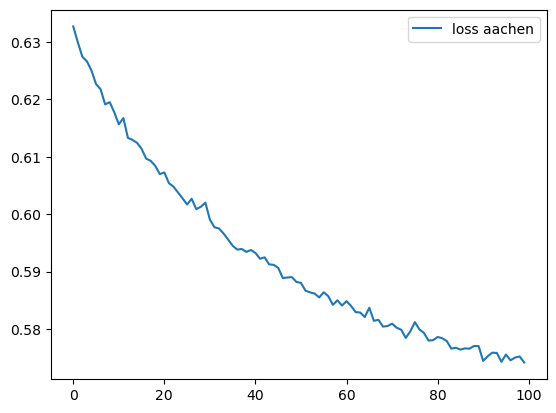

In [16]:
x = np.linspace(0,100-1 , 100)
plt.plot(x, losses, label="loss aachen")
plt.legend()
plt.show()

In [17]:
def get_true_labels(data_loader):
    labels = []
    for batch in data_loader:
        _, batch_labels = batch
        labels.append(batch_labels.to(torch.device("cpu")).numpy().tolist())
    labels = np.concatenate(labels)
    
    return np.array(labels)

def calculate_errors(LCT_model, dataloader):
    output =[]
    #print(CLR_model)
    #print(LCT_model)
    LCT_model.eval()
    with torch.no_grad(): # turn off gradients since we're only evaluating
        for inputs, labels in dataloader:
            
            point_on_sphere =inputs
            outputs = LCT_model(point_on_sphere).to(torch.device("cpu"))
            
            output.append(outputs)

    output = np.concatenate(output)

    return np.array(output)


output_net=calculate_errors(linear_model,dl_AE_testing_aachen)
labels_net = get_true_labels(dl_AE_testing_aachen)

print(output_net)

[[ 0.95636016]
 [ 1.9740932 ]
 [-1.4011908 ]
 ...
 [ 2.4121256 ]
 [ 1.1112814 ]
 [-0.16353811]]


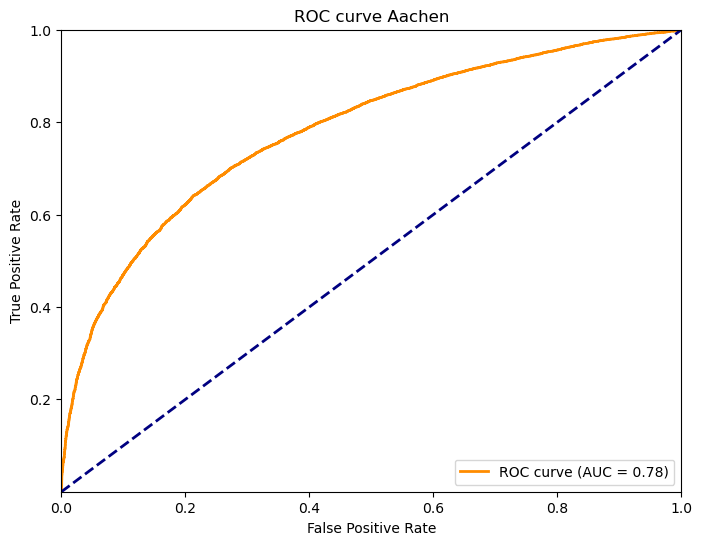

In [18]:
output_net=calculate_errors(linear_model,dl_AE_testing_aachen)
labels_net = get_true_labels(dl_AE_testing_aachen)

fpr, tpr, thresholds = roc_curve(labels_net, output_net) #getting the data needed to plot the ROC curve
roc_auc = auc(fpr, tpr) #getting the AUC

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([1e-4, 1.0])  # set the lower limit to 0.0001 for logarithmic y-axis
plt.xscale('linear')     # set x-axis to linear scale
#plt.yscale('log')        # set y-axis to logarithmic scale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Aachen')
plt.legend(loc="lower right")
plt.show()

# Checking stuff


## N-subjettiness

In [ ]:
import numpy as np
import fastjets
from pyjet import cluster
from pyjet import Nsubjettiness

# Assuming you have a DataLoader called 'dataloader' containing your jet data
nsub_values = []

for batch in dl_training:
    pt = batch[:, 0]
    eta = batch[:, 1]
    phi = batch[:, 2]

    # Convert the jet data to cartesian coordinates
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    
    # Create a list to store N-subjettiness values for each jet in the batch
    nsub_batch = []
    
    for i in range(len(pt)):
        # Perform jet clustering using anti-kt algorithm with radius R
        sequence = cluster(px[i], py[i], pz[i], pt[i])
        jets = sequence.inclusive_jets()

        # Calculate N-subjettiness for each jet
        tau = Nsubjettiness(1, axes_radius=1.0)
        tau_val = tau(jets[0])

        # Append N-subjettiness value to the batch list
        nsub_batch.append(tau_val)
    
    # Append batch list to the overall list
    nsub_values.extend(nsub_batch)


### visualize

#### tSNE

In [ ]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming you have a DataLoader called 'dataloader' containing your tensors
data = []
labels = []
# Collect all the data from the DataLoader
with torch.no_grad(): # turn off gradients since we're only evaluating
        for inputs, label in dl_AE_testing_aachen:
            x_i = inputs
            x_i =  x_i.transpose(1,2)
            point_on_sphere = net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask )
            data.append(point_on_sphere.cpu())

            labels.append(label.cpu())

        data = torch.cat(data, dim=0)
        labels = torch.cat(labels,dim=0)

# Apply t-SNE to reduce the dimensionality to 2
tsne = TSNE(n_components=2)
embedded_data = tsne.fit_transform(data)


#color
# Assign a color to each fitting label
colors = ['r', 'b']
origin = ['QCD','Semi_Aachen']

for i, kind in enumerate(torch.unique(labels)):
    mask = labels == kind
    plt.scatter(embedded_data[mask, 0], embedded_data[mask, 1], c=colors[i], label=origin[int(kind.item())])


# Plot the embedded data

plt.title("t-SNE Visualization")
plt.legend()
plt.show()


### Random

In [ ]:
data_path = "/remote/gpu05/rueschkamp/data/Luidata/datasets/qcd_constit.h5"
data_frame = pd.read_hdf(data_path, key='table', start=0, stop=1)
data_frame

In [ ]:
mean= []

for i,(data,labels) in enumerate(dl_training):

    x = data
    pTs_mean = torch.mean(x[:,0,:])
    mean.append(pTs_mean.cpu())
    

    

In [ ]:
print(len(mean))
print(np.mean(mean))

In [ ]:
max= []

for i,(data,labels) in enumerate(dl_training):

    x = data
    pTs_max = torch.max(x[:,0,:])
    max.append(pTs_max.cpu())

print(np.max(max))

In [ ]:
max= []

for i,(data,labels) in enumerate(dl_AE_testing_aachen):

    x = data
    pTs_max = torch.max(x[:,0,:])
    max.append(pTs_max.cpu())

print(np.max(max))

In [ ]:
!nvidia-smi

-9